In [ ]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import imageio
import imageio.v2 as imageio
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Parameters and Basic settings

In [ ]:
E_real = 10.
nu_real = 0.3
G_real = E_real/(2*(1+nu_real))
nu_init = 0.2
E_init = 4.
Force = 1.

Train_with_ADAM = False
Train_with_LBFGS = True

seed_id = 1234

################################################ COMPLETAR
ADAM_steps =
lr =
nneurons =
nhiden_layers =
w_loss_f =
w_loss_bc =
w_loss_d =
Nf_x =  # Number of collocation points in x direction
Nf_y =  # Number of collocation points in y direction
N_bc =  # Number of boundary points
###########################################################

print('E_real is: ', E_real)
print("Our guess of E is :", E_init)


# Set default dtype to float32
torch.set_default_dtype(torch.float)
# PyTorch random number generator
torch.manual_seed(seed_id)
# Random number generators in other libraries
np.random.seed(seed_id)

E_real is:  10.0
Our guess of E is : 4.0


## Normalization

In [ ]:
def normalize(X_tensor, X_min, X_max):
    """
    Normalize a tensor by columns given a max and min of each column.

    Parameters:
    X_tensor(numpy array): Tensor to be normalized.
    """
    # Normalize input vector X by each feature
    (num_row_X, num_col_X) = X_tensor.shape
    normalized_X_tensor = torch.zeros_like(X_tensor)

    # Fill the copy vector
    for col in range(num_col_X):
        min_X_col = X_min[col]
        max_X_col = X_max[col]
        normalized_X_tensor[:,col] = (X_tensor[:,col]-min_X_col)*2/(max_X_col-min_X_col) -1

    return normalized_X_tensor

def unnormalize(X_tensor, X_min, X_max):
    """
    Unnormalize a tensor by columns given a max and min of each column.

    Parameters:
    X_tensor(numpy array): Tensor to be unnormalized.
    X_max(numpy array): Max of each column of the tensor to be unnormalized.
    X_min(numpy array): Min of each column of the tensor to be unnormalized.
    """
    # Unnormalize input vector X by each feature
    (num_row_X, num_col_X) = X_tensor.shape
    unnormalized_X_tensor = torch.zeros_like(X_tensor)

    # Fill the copy vector
    for col in range(num_col_X):
        unnormalized_X_tensor[:,col] = (X_tensor[:,col]+1)*(X_max[col]-X_min[col])/2 + X_min[col]

    return unnormalized_X_tensor

## Loading data

In [ ]:
displacement_data_path = relative_csv_path =  "/content/drive/MyDrive/Taller PINNs/Calse_4/Displacement.csv"                 # path to displacement data
ititialPosition_data_path = "/content/drive/MyDrive/Taller PINNs/Calse_4/InitialPosition.csv"                # path to initial position data
displacement_header= ['Node','u','v','w']                               # header of displacement data
initialPosition_header = ['Node','x','y','z']                           # header of initial position data

displacement_df = pd.read_csv(displacement_data_path,header=None)       # Reading data
displacement_df.columns = displacement_header                           # Assigning column names
initialPosition_df = pd.read_csv(ititialPosition_data_path,header=None) # Reading data
initialPosition_df.columns = initialPosition_header                     # Assigning column names

# Extracting data

fields_u_extended = ['u','v', 'w']                              # Not considering the z component
fields_x = ['x','y']                                            # Not considering the z component
fields_x_extended = ['x','y','z']                               # Considering the z component

X_real_extended = initialPosition_df[fields_x_extended]         # All the coordinates
front_b = max(X_real_extended.z)                                # Max z coordinate
back_b = min(X_real_extended.z)                                 # Min z coordinate
X_real_extended = X_real_extended[X_real_extended.z != front_b] # Remove duplicates in z direction
X_real = X_real_extended.drop(columns=['z'])                    # Remove z component

X_real_extended = X_real_extended.to_numpy()                    # Convert to numpy array
X_real_extended = X_real_extended.astype(np.float32)            # Convert to float32
X_real = X_real.to_numpy()                                      # Convert to numpy array
X_real = X_real.astype(np.float32)                              # Convert to float32
X_real = torch.tensor(X_real)                                   # Convert to tensor

# # Geometrical bounds
left_b = min(X_real_extended[:,0])
right_b = max(X_real_extended[:,0])
bottom_b = min(X_real_extended[:,1])
top_b = max(X_real_extended[:,1])
height = top_b - bottom_b
depth = front_b - back_b
length = right_b - left_b
A_front = depth*height
X_min = torch.tensor([left_b, bottom_b, back_b])
X_max = torch.tensor([right_b, top_b, front_b])
print('The boundaries are: left =',left_b,'right =',right_b,'bottom =',bottom_b,'top =',top_b, 'front =',front_b, 'back =',back_b)
print("The applied force is:",Force, "over an area of:",A_front, "resulting in a stress of:",Force/A_front)

# Obtaining the displacement data
U_real = displacement_df[fields_u_extended]                     # All the displacements
U_real['w'].round(decimals=1)                                   # round 'w' column
max_Uw = max(U_real.w)                                          # Max w displacement
min_Uw = min(U_real.w)                                          # Min w displacement
U_real = U_real[U_real.w != min_Uw]                             # Remove duplicates in w displacement
U_real = U_real.drop(columns=['w'])                             # Remove w component

U_real = U_real.to_numpy()                                      # Convert to numpy array
U_real = U_real.astype(np.float32)                              # Convert to float32
U_real = torch.from_numpy(U_real)                               # Convert to tensor



The boundaries are: left = -15.0 right = 15.0 bottom = -5.0 top = 5.0 front = 1 back = 0
The applied force is: 1.0 over an area of: 10.0 resulting in a stress of: 0.1


## Collocation points and auxiliary vectors

In [ ]:
## Collocation points for PDF
X_f = np.random.uniform(left_b, right_b, (Nf_x, 1))                     # Random points in x direction
Y_f = np.random.uniform(bottom_b, top_b, (Nf_y, 1))                     # Random points in y direction
comb_array = np.array(np.meshgrid(X_f, Y_f)).T.reshape(-1, 2)           # Combine the two arrays
comb_array = comb_array.astype(np.float32)                              # Convert to float32
X_train_f = torch.tensor(comb_array)                       # Convert to tensor the collocation points

# Collocation point for BC
distance = height/(N_bc-1)
X_bc_y = np.linspace(bottom_b+distance/2, top_b-distance/2, N_bc).reshape(N_bc,1)       # Equispaced points in y direction
X_bc_x = np.ones(N_bc)*right_b                                                          # Boundary conditions indexes
X_bc_x = X_bc_x.reshape(N_bc,1)                                                         # Reshape
X_bc = np.concatenate((X_bc_x, X_bc_y), axis=1)                                         # Combine the two arrays
X_bc = X_bc.astype(np.float32)                                                          # Convert to float32
X_bc = torch.from_numpy(X_bc)                                                           # Convert to tensor

s_x = Force/A_front
Stress_bc = torch.ones_like(X_bc[:,0])*s_x
Stress_bc = Stress_bc.reshape(N_bc,1)


f_hat = torch.zeros(Nf_x*Nf_y, 2)
print("The number of collocation points for the PDE is:",Nf_x*Nf_y)
print("The number of collocation points for the BC is:", N_bc)

The number of collocation points for the PDE is: 4000
The number of collocation points for the BC is: 50


## Plot of the data set

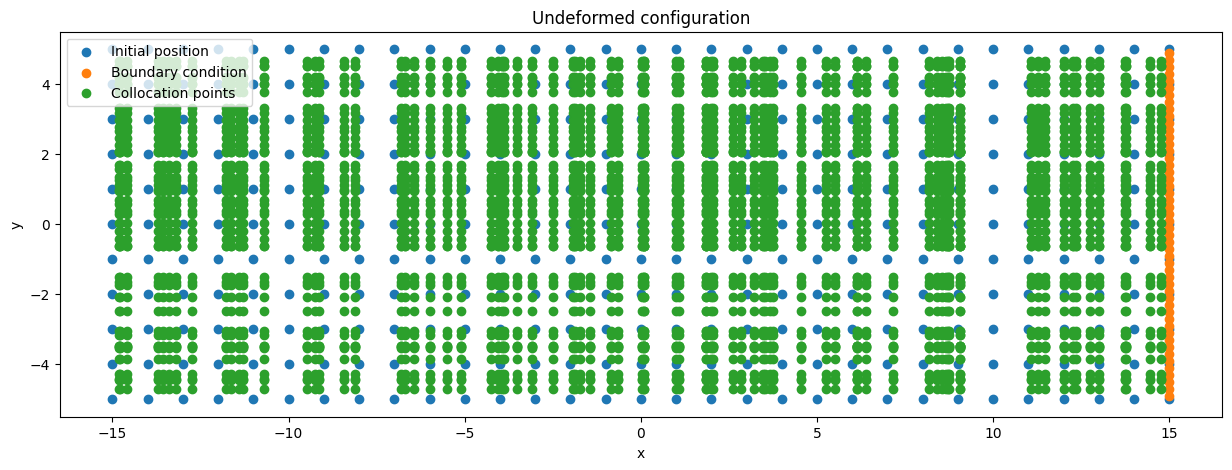

In [ ]:
## Plot the data
plt.figure()
plt.scatter(X_real[:,0], X_real[:,1], label='Initial position')
plt.scatter(X_bc[:,0], X_bc[:,1], label='Boundary condition')
plt.scatter(X_train_f[:,0], X_train_f[:,1], label='Collocation points')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Undeformed configuration')
# set size of the figure
plt.gcf().set_size_inches(15, 5)
plt.legend()
plt.show()


## Defining architecture

In [ ]:
input_dim = X_real.shape[1]
output_dim = U_real.shape[1]
layers = np.array([input_dim] + [ nneurons for i in range(nhiden_layers)] + [output_dim])

## Deep NN class

In [ ]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class

        'activation function'
        self.activation = nn.Tanh()

        'Initialize neural network as a list using nn.Modulelist'
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])

        'Xavier Normal Initialization'
        for i in range(len(layers)-1):

            # set standard deviation for initialization
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)

            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

    'foward pass'
    def forward(self,x):

        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)

        #convert to float
        a = x.float()

        # inpunt and hidden layers forward computation
        for i in range(len(layers)-2):

            z = self.linears[i](a)

            a = self.activation(z)

        # output layer forward computation
        a = self.linears[-1](a)

        return a

## PINN class

In [ ]:
class PINN():
    def __init__(self, layers):

        'Define loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')

        'Initialize iterator'
        self.iter = 0

        'Initialize our new parameter as tensor (Inverse problem)'
        self.E = torch.tensor([float(E_init)], requires_grad=True).float()

        'Register parametes to be optimized'
        self.E = nn.Parameter(self.E)

        'Initialize our DNN'
        self.dnn = DNN(layers)

        'Register our new parameter'
        self.dnn.register_parameter('E', self.E)

        'History of losses'
        self.loss_history = {"Data": [],
                             "PDE": [],
                             "BC": [],
                             "Total":[]}

        'Parameters trials'
        self.params_history = {"E": [] }

    def loss_data(self, x, u_real, save = False):

        ################################################ COMPLETAR


        save and self.loss_history["Data"].append(loss_d.to('cpu').detach().numpy())

        return loss_d

    def loss_PDE(self, pos_f, save = False):

        # extract the PDE parameters
        E = self.E
        nu = nu_real
        # G = E/(2*(1+nu))

        # clone the input data and add AD
        pos = pos_f.clone()
        pos.requires_grad = True

        # predict u
        U = self.dnn(pos)

        ################################################ COMPLETAR

        u_xx = ddU[:,0].reshape(-1,1)
        v_yy = ddU[:,1].reshape(-1,1)

        # Shift columns of du tensor
        dU_shifted = torch.roll(dU, 1, 1)

        u_xy = cross_ddU[:,1].reshape(-1,1)
        v_yx = cross_ddU[:,0].reshape(-1,1)


        ################################################ COMPLETAR
        # PDE f = 0


        f_tensor= torch.cat((f[0] , f[1]), dim=1).to(torch.float32)

        ################################################ COMPLETAR
        # Compute the loss_f


        save and self.loss_history["PDE"].append(loss_f.to('cpu').detach().numpy())

        return loss_f

    def loss_BC(self, pos_bc, save = False):

        # extract the PDE parameters
        E = self.E
        nu = nu_real
        # G = E/(2*(1+nu))

        # clone the input data and add AD
        pos = pos_bc.clone()
        pos.requires_grad = True

        # predict U
        U = self.dnn(pos)

        ################################################ COMPLETAR
        # compute the derivatives togheter


        ################################################ COMPLETAR
        # compute s11_pred


        ################################################ COMPLETAR
        # Compute the loss_bc

        save and self.loss_history["BC"].append(loss_bc.to('cpu').detach().numpy())

        return loss_bc

    def loss(self, pos_real, despl_real, pos_f, pos_bc, save = False):

        loss_d  = self.loss_data(pos_real, despl_real, save)
        loss_f  = self.loss_PDE(pos_f, save)
        loss_bc = self.loss_BC(pos_bc, save)

        # weights should sum 1
        loss_val = w_loss_d*loss_d + w_loss_f*loss_f + w_loss_bc*loss_bc

        if save:
            self.loss_history["Total"].append(loss_val.to('cpu').detach().numpy())
            self.params_history["E"].append(self.E.to('cpu').data.numpy().copy())
        return loss_val

    'callable for optimizer'
    def closure(self):

        optimizer.zero_grad()

        loss = self.loss(X_real, U_real, X_train_f, X_bc, True)

        loss.backward()

        self.iter += 1

        print(
            'LBFGS iter: %d, Loss total: %.10f, E_PINN/E_real = %.3f / %.3f' %
            (
                self.iter,
                loss.cpu().detach().numpy(),
                self.E.item(),
                E_real
            )
        )

        return loss

    'foward pass'
    def forward(self,pos):
        return self.dnn(pos)


## Training

In [ ]:
if Train_with_ADAM:
    ### TRAINING WITH ADAM ###

    print('Training with ADAM')

    'Neural Network Summary'
    pinn = PINN(layers)
    'Neural Network Parameters'
    params = list(pinn.dnn.parameters())

    'ADAM Optimizer'
    optimizer = torch.optim.Adam(params, lr,
                                amsgrad = True,
                                betas=(0.9, 0.999))

    # Measure time
    start_time_ADAM = time.time()
    # Training
    for epoch in range(ADAM_steps+1):

        loss = pinn.loss(X_real, U_real, X_train_f, X_bc, True)

        pinn.iter += 1

        print(
            'ADAM iter: %d, Loss total: %.10f, E_PINN/E_real = %.3f / %.3f ' %
            (
                pinn.iter,
                loss.cpu().detach().numpy(),
                pinn.E.item(),
                E_real
            )
        )

        optimizer.zero_grad()       # Zero Out the gradient
        loss.backward()
        optimizer.step()

    elapsed_time_ADAM = (time.time() - start_time_ADAM)/60
    print('Elapsed time ADAM: %.2f minutes.' % elapsed_time_ADAM)

if Train_with_LBFGS:
    ### TRAINING WITH ADAM ###

    print('Training with L-BFGS')

    'Neural Network Summary'
    pinn = PINN(layers)

    'Neural Network Parameters'
    params = list(pinn.dnn.parameters())

    'Mesure time'
    start_time_LBFGS = time.time()

    'L-BFGS Optimizer'
    optimizer = torch.optim.LBFGS(params, lr,
                                    max_iter = 5000,
                                    max_eval = None,
                                    tolerance_grad = 1e-12,
                                    tolerance_change = 1e-12,
                                    line_search_fn = 'strong_wolfe',
                                    history_size = 100)

    optimizer.step(pinn.closure)

    elapsed_time_LBFGS = (time.time() - start_time_LBFGS)/60

    print('Elapsed time L-BFGS: %.2f minutes' % elapsed_time_LBFGS)

Training with L-BFGS
LBFGS iter: 1, Loss total: 9.7299251556, E_PINN/E_real = 4.000 / 10.000
LBFGS iter: 2, Loss total: 7.8092999458, E_PINN/E_real = 4.000 / 10.000
LBFGS iter: 3, Loss total: 3.1167216301, E_PINN/E_real = 3.999 / 10.000
LBFGS iter: 4, Loss total: 1.5232684612, E_PINN/E_real = 3.999 / 10.000
LBFGS iter: 5, Loss total: 0.8202986717, E_PINN/E_real = 3.999 / 10.000
LBFGS iter: 6, Loss total: 0.4411371946, E_PINN/E_real = 3.999 / 10.000
LBFGS iter: 7, Loss total: 0.2470728010, E_PINN/E_real = 3.998 / 10.000
LBFGS iter: 8, Loss total: 0.1628949642, E_PINN/E_real = 3.998 / 10.000
LBFGS iter: 9, Loss total: 0.1348634213, E_PINN/E_real = 3.998 / 10.000
LBFGS iter: 10, Loss total: 0.1177517474, E_PINN/E_real = 3.997 / 10.000
LBFGS iter: 11, Loss total: 0.0987160429, E_PINN/E_real = 3.997 / 10.000
LBFGS iter: 12, Loss total: 0.0810186341, E_PINN/E_real = 3.997 / 10.000
LBFGS iter: 13, Loss total: 0.0695418343, E_PINN/E_real = 3.996 / 10.000
LBFGS iter: 14, Loss total: 0.061938535

KeyboardInterrupt: 

## Loss evolution

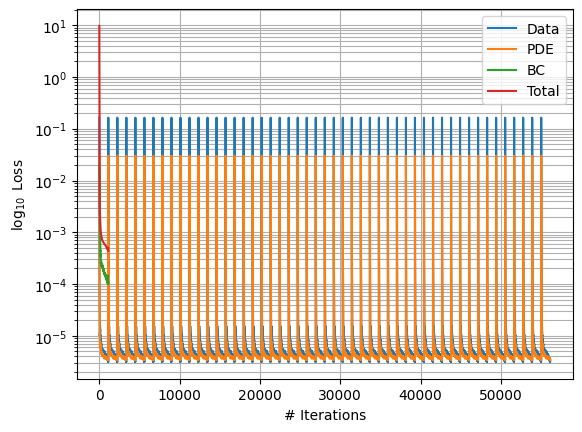

In [ ]:
# print los history with log scale
plt.plot(w_loss_d*pinn.loss_history["Data"], label='Data')
plt.plot(w_loss_f*pinn.loss_history["PDE"], label='PDE')
plt.plot(w_loss_bc*pinn.loss_history["BC"], label='BC')
plt.plot(pinn.loss_history["Total"], label='Total')
plt.yscale('log')
plt.xlabel('# Iterations')
plt.ylabel(r'$\log_{10}$ Loss')
# grid
plt.grid(True, which="both", ls="-")
plt.legend()
plt.show()

# Verification

## Parameter Evolution

In [ ]:
# Plot mesh of displacements and original position in red and blue respectively

################################################ COMPLETAR
# Compute X_real, Xfinal_real y X_finalpred

plt.scatter(X_real[:,0], X_real[:,1], c='k', label='Inicial', s=30, alpha=0.5)
plt.scatter(X_final_real[:,0], X_final_real[:,1], c="blue", label='Real', s=30)
plt.scatter(X_final_pred[:,0], X_final_pred[:,1], c='r', label='Predicted', s=5)
plt.xlim(-16, 16)
plt.ylim(-6, 10)
plt.legend(loc='best')
# define size of figure
fig = plt.gcf()
fig.set_size_inches(20, 10)

plt.show()

In [ ]:
# plor G_real and G_PINN evolution
plt.plot(pinn.params_history["E"], label='E_PINN')
plt.plot(np.ones(len(pinn.params_history["E"]))*E_real, label='E_real')
plt.legend()
# add axe legend
plt.xlabel('# Iterations')
plt.ylabel('E')
plt.grid(True, which="both", ls="-")

plt.show()
